# Find circuits based on their interaction strengths

In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)
    

from src.srv.sequence_exploration.sequence_analysis import b_tabulate_mutation_info, pull_circuits_from_stats
from src.srv.parameter_prediction.interactions import INTERACTION_FIELDS_TO_WRITE
from src.utils.common.setup_new import construct_circuit_from_cfg
from src.utils.circuit.agnostic_circuits.circuit_manager import CircuitModeller
from src.utils.misc.numerical import nan_to_replacement_string, count_monotonic_group_lengths
from src.utils.misc.string_handling import string_to_tuple_list
from src.utils.misc.type_handling import flatten_listlike
from src.utils.modelling.physical import equilibrium_constant_reparameterisation, F, gibbs_K_cal
from src.utils.results.analytics.naming import get_true_names_analytics, get_true_interaction_cols
from src.utils.common.testing.shared import CONFIG, five_circuits

from copy import deepcopy


config = deepcopy(CONFIG)

In [ ]:
circuits, config, data_writer = five_circuits(
    config, data_writer=None)



In [42]:
stats_pathnames = [
    '../data/ensemble_generate_circuits/2023_02_23_174630/gather_interaction_stats/circuit_stats.csv',
    '../data/ensemble_generate_circuits/2023_02_24_170946/gather_interaction_stats/circuit_stats.csv',
    '../data/gather_interaction_stats/2023_03_29_185202/circuit_stats.csv',
    '../data/gather_interaction_stats/2023_03_30_232358/circuit_stats.csv',
    '../data/gather_interaction_stats/2023_03_31_110727/circuit_stats.csv'
]

df = pd.concat([pd.read_csv(s) for s in stats_pathnames])


Process the binding sites, which are currently just strings.

In [43]:
def replace_single_bracket(x):
    if x == '(':
        return ''
    return x

In [44]:
df[get_true_interaction_cols(df, 'binding_sites')] = df[get_true_interaction_cols(df, 'binding_sites')].apply(nan_to_replacement_string)
df[get_true_interaction_cols(df, 'binding_sites')] = df[get_true_interaction_cols(df, 'binding_sites')].applymap(replace_single_bracket)
df[get_true_interaction_cols(df, 'binding_sites')] = df[get_true_interaction_cols(df, 'binding_sites')].applymap(string_to_tuple_list)
binding_site_length_cols = [b + '_lengths' for b in get_true_interaction_cols(df, 'binding_sites')]
df[binding_site_length_cols] = df[get_true_interaction_cols(df, 'binding_sites')].applymap(lambda x: count_monotonic_group_lengths([i[0] for i in x]))
binding_site_count_cols = [b + '_counts' for b in get_true_interaction_cols(df, 'binding_sites')]
df[binding_site_count_cols] = df[binding_site_length_cols].applymap(len)
df['circuit_idx'] = df.index



naming.py:get_true_interaction_cols():88: Assuming that the number of species is 3 WARNING
naming.py:get_true_interaction_cols():88: Assuming that the number of species is 3 WARNING
naming.py:get_true_interaction_cols():88: Assuming that the number of species is 3 WARNING
naming.py:get_true_interaction_cols():88: Assuming that the number of species is 3 WARNING
naming.py:get_true_interaction_cols():88: Assuming that the number of species is 3 WARNING
naming.py:get_true_interaction_cols():88: Assuming that the number of species is 3 WARNING
naming.py:get_true_interaction_cols():88: Assuming that the number of species is 3 WARNING
naming.py:get_true_interaction_cols():88: Assuming that the number of species is 3 WARNING
naming.py:get_true_interaction_cols():88: Assuming that the number of species is 3 WARNING


TypeError: 'Int64Index' object is not callable

In [47]:
print(f'We are currently looking at {len(df)} different circuits - names repeat becasue some are mutations and these have yet to be labelled in the table.')

We are currently looking at 1598075 different circuits - names repeat becasue some are mutations and these have yet to be labelled in the table.


naming.py:get_true_interaction_cols():88: Assuming that the number of species is 3 WARNING
naming.py:get_true_interaction_cols():88: Assuming that the number of species is 3 WARNING
naming.py:get_true_interaction_cols():88: Assuming that the number of species is 3 WARNING
naming.py:get_true_interaction_cols():88: Assuming that the number of species is 3 WARNING
naming.py:get_true_interaction_cols():88: Assuming that the number of species is 3 WARNING


<AxesSubplot: xlabel='energies', ylabel='binding_site_count'>

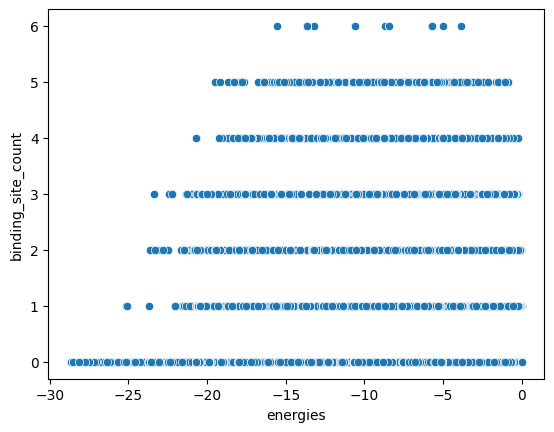

In [48]:
dfma = df.melt(['name', 'num_interacting', 'num_self_interacting'], value_vars=get_true_interaction_cols(df, 'energies'), var_name='energies_type', value_name='energies')

for interacc in INTERACTION_FIELDS_TO_WRITE:
    dfm = df.melt(['name', 'num_interacting', 'num_self_interacting'], value_vars=get_true_interaction_cols(df, interacc), var_name=f'{interacc}_type', value_name=interacc)
    dfma[f'{interacc}_type'] = dfm[f'{interacc}_type']
    dfma[interacc] = dfm[interacc]

dfm = df.melt(['name', 'num_interacting', 'num_self_interacting'], value_vars=binding_site_length_cols, var_name=f'binding_sites_type', value_name='binding_sites_length')
dfma['binding_sites_length'] = dfm['binding_sites_length']
dfm = df.melt(['name', 'num_interacting', 'num_self_interacting'], value_vars=binding_site_count_cols, var_name=f'binding_sites_type', value_name='binding_site_count')
dfma['binding_site_count'] = dfm['binding_site_count']

sns.scatterplot(dfma[dfma['energies'] <= 0], x='energies', y='binding_site_count')

What are the Gibbs free energy vs. the reparameterised energies like?

In [49]:
energies_cols = get_true_interaction_cols(df, 'energies', num_species=3)


naming.py:get_true_interaction_cols():88: Assuming that the number of species is 3 WARNING


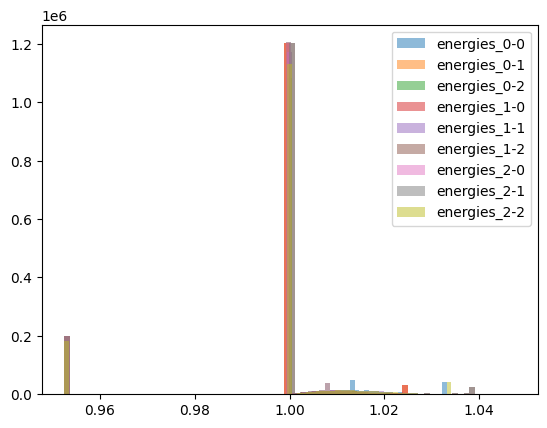

In [50]:
gibbs = df[energies_cols].apply(gibbs_K_cal)

for col in energies_cols:
    plt.hist(gibbs[col], bins=80, alpha=0.5)
plt.legend(energies_cols)


And the reparameterised equilibrium constants:

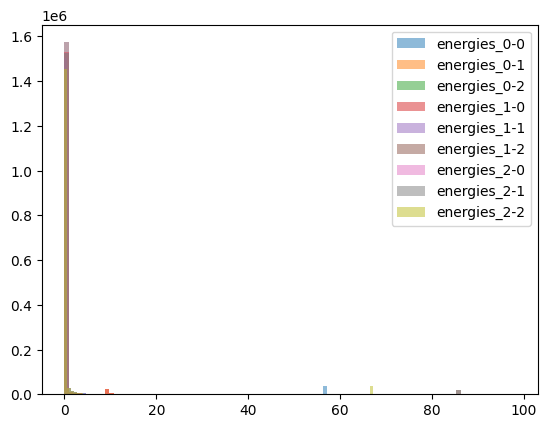

In [51]:
fluor = df[energies_cols].apply(equilibrium_constant_reparameterisation)

for col in energies_cols:
    plt.hist(fluor[col], bins=100, alpha=0.5)
plt.legend(energies_cols)


Let's look at some circuits that are a bit stronger

In [52]:
strong_circuits = df[(df['num_interacting'] >= 3)] #  | ((df['num_self_interacting'] >= 3) & (df['num_interacting'] >= 1))]
print('Proportion of randomly generated circuits that are strong: ', len(strong_circuits)/len(df))

Proportion of randomly generated circuits that are strong:  0.0003078704065829201


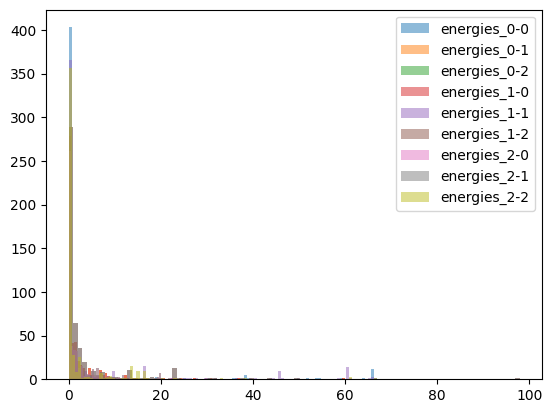

In [53]:

fluor = strong_circuits[energies_cols].apply(equilibrium_constant_reparameterisation)

for col in energies_cols:
    plt.hist(fluor[col], bins=100, alpha=0.5)
plt.legend(energies_cols)


Even randomly generated circuits can have high binding energies. However, it takes a particular combination of circuits to achieve adaptive behavior. In parameter scans, circuits where at least one of the species could achieve robustly adaptive behavior (ie having a precision >= 10 an a sensitivity >= 1) had equilibrium constants with ca. 4 orders of magnitude difference between each other. 

In [54]:
energies = df.melt(['name'], value_vars=energies_cols, value_name='energies', var_name='energies_idx')
dfma = df.melt(['name', 'num_interacting', 'num_self_interacting'], value_vars=get_true_interaction_cols(df, 'energies'), var_name='energies_type', value_name='energies')

for interacc in INTERACTION_FIELDS_TO_WRITE:
    if interacc == 'energies':
        continue
    dfm = df.melt(['name', 'num_interacting', 'num_self_interacting'], value_vars=get_true_interaction_cols(df, interacc), var_name=f'{interacc}_type', value_name=interacc)
    dfma[f'{interacc}_type'] = dfm[f'{interacc}_type']
    dfma[interacc] = dfm[interacc]

dfm = df.melt(['name', 'num_interacting', 'num_self_interacting'], value_vars=binding_site_length_cols, var_name=f'binding_sites_type', value_name='binding_sites_length')
dfma['binding_sites_length'] = dfm['binding_sites_length']
dfm = df.melt(['name', 'num_interacting', 'num_self_interacting'], value_vars=binding_site_count_cols, var_name=f'binding_sites_type', value_name='binding_site_count')
dfma['binding_site_count'] = dfm['binding_site_count']

dfma.loc[energies['name'] != 0, 'energies'] = energies.apply({'energies': lambda x: np.where(x >= 0, 0, x)})
dfma

naming.py:get_true_interaction_cols():88: Assuming that the number of species is 3 WARNING
naming.py:get_true_interaction_cols():88: Assuming that the number of species is 3 WARNING
naming.py:get_true_interaction_cols():88: Assuming that the number of species is 3 WARNING
naming.py:get_true_interaction_cols():88: Assuming that the number of species is 3 WARNING


,name,num_interacting,num_self_interacting,energies_type,energies,binding_sites_type,binding_sites,binding_rates_dissociation_type,binding_rates_dissociation,eqconstants_type,eqconstants,binding_sites_length,binding_site_count
0,toy_mRNA_circuit_0,0,0,energies_0-0,0.00,binding_sites_0-0,[],binding_rates_dissociation_0-0,171.397370,eqconstants_0-0,0.000009,[],0
1,toy_mRNA_circuit_10000,0,0,energies_0-0,0.00,binding_sites_0-0,[],binding_rates_dissociation_0-0,171.397370,eqconstants_0-0,0.000009,[],0
2,toy_mRNA_circuit_10001,1,1,energies_0-0,-6.94,binding_sites_0-0,"[(8, 20), (9, 19), (10, 17), (11, 16), (12, 15...",binding_rates_dissociation_0-0,0.000102,eqconstants_0-0,14.771485,"[10, 2]",2
3,toy_mRNA_circuit_10002,1,0,energies_0-0,0.00,binding_sites_0-0,[],binding_rates_dissociation_0-0,171.397370,eqconstants_0-0,0.000009,[],0
4,toy_mRNA_circuit_10003,0,0,energies_0-0,0.00,binding_sites_0-0,[],binding_rates_dissociation_0-0,171.397370,eqconstants_0-0,0.000009,[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14382670,toy_circuit_combo0_4209,0,0,energies_2-2,0.00,binding_sites_2-2,[],binding_rates_dissociation_2-2,0.226320,eqconstants_2-2,0.006670,[],0
14382671,toy_circuit_combo0_4209,0,0,energies_2-2,0.00,binding_sites_2-2,[],binding_rates_dissociation_2-2,0.226320,eqconstants_2-2,0.006670,[],0
14382672,toy_circuit_combo0_4209,0,0,energies_2-2,0.00,binding_sites_2-2,[],binding_rates_dissociation_2-2,0.226320,eqconstants_2-2,0.006670,[],0
14382673,toy_circuit_combo0_4209,0,0,energies_2-2,0.00,binding_sites_2-2,[],binding_rates_dissociation_2-2,0.226320,eqconstants_2-2,0.006670,[],0


<AxesSubplot: xlabel='energies', ylabel='binding_site_count'>

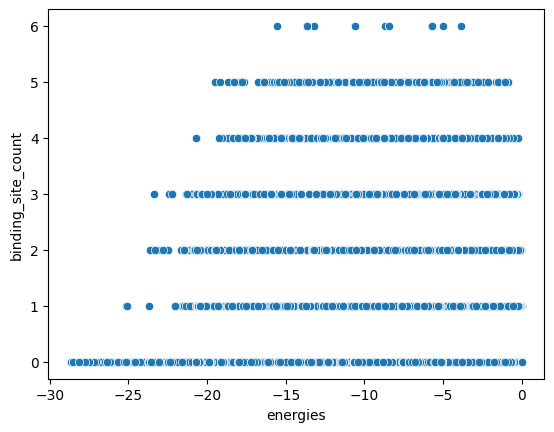

In [55]:
sns.scatterplot(dfma, x='energies', y='binding_site_count')


In [56]:
print('The fraction of circuit interactions with an interaction strength of 0 is', np.sum(energies['energies'] == 0) / len(energies))

The fraction of circuit interactions with an interaction strength of 0 is 0.7362758318602068


(array([2.000000e+00, 1.400000e+01, 3.000000e+01, 3.520000e+02,
        1.124000e+03, 2.112000e+03, 3.274000e+03, 8.278000e+03,
        1.330500e+04, 1.766800e+04, 2.528300e+04, 3.652100e+04,
        4.602100e+04, 5.755100e+04, 6.657000e+04, 6.632500e+04,
        6.234900e+04, 5.193600e+04, 3.615500e+04, 3.735805e+06]),
 array([-25.14 , -23.883, -22.626, -21.369, -20.112, -18.855, -17.598,
        -16.341, -15.084, -13.827, -12.57 , -11.313, -10.056,  -8.799,
         -7.542,  -6.285,  -5.028,  -3.771,  -2.514,  -1.257,   0.   ]),
 <BarContainer object of 20 artists>)

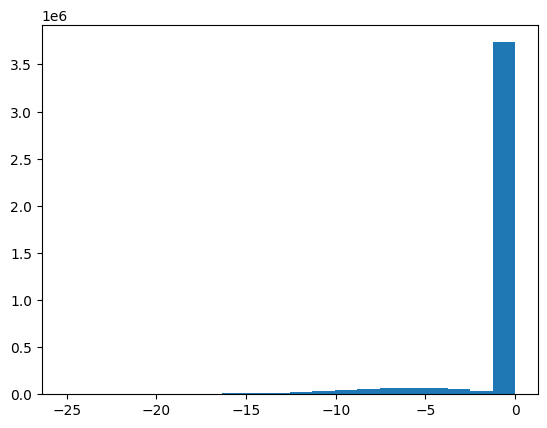

In [ ]:
plt.hist(energies['energies'], bins=20)

In [ ]:
energies['K_eq_factors'] = energies['energies'].apply(equilibrium_constant_reparameterisation)
K_eq_factors = energies.groupby(['name']).agg({'K_eq_factors': lambda x: x.max() / x.min()})


Text(0.5, 0, '$K_{eq}$ max / min')

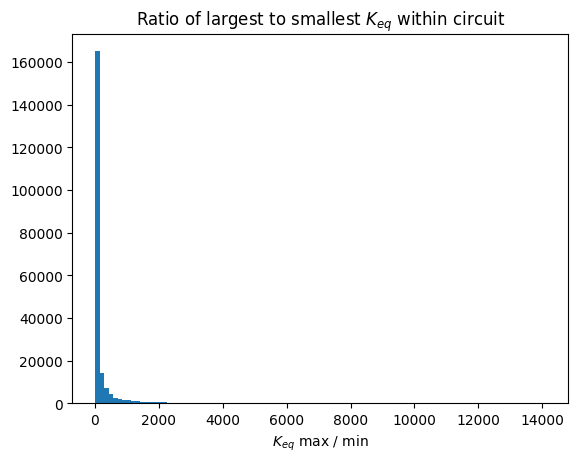

In [ ]:
plt.hist(K_eq_factors['K_eq_factors'], bins=100)
plt.title(r'Ratio of largest to smallest $K_{eq}$ within circuit')
plt.xlabel(r'$K_{eq}$ max / min')
# plt.xscale('log')

### More Statistics of randomly generated circuits

Below are some stats on a batch of 20000 circuits that were generated randomly, albeit from a distribution of RNA nucleotides where each had a probability weighting corresponding to its abundance in the E. coli genome. Species are considered interacting if the equilibrium constant is greater than 1. Something that becomes obvious when grouping the binding energies by the number of interacting and self-interacting RNA species is that
- only 25/20000 = 0.125% circuits have 3 interactions (between different species)
- self-interacting species do not reach as negative binding energies
- the stronger the binding energy, the more nucleotides are bound together
- the most negative binding energy (ca. -9kcal/mol) corresponds to an equilibrium constant (ca. 0.01) from the fluorescence parameterisation that is still well below $K = 1$, meaning that if the criteria for species interacting were based on this new equilibrium constant, none of the circuits would be considered interacting. Perhaps 

The following plots may be a bit misleading, as they appear to maintain the true spread of each of the features, but this is not the case - each stacked bar plot is adding up the blocks together, so a bar going from 0-100 with 5 blocks would mean each block has a value of around 20, while a bar that spans across 0 has blocks with negative values added together. The purpose is to show the rough length of each block, as well as highlighting differences between the spans of blocks at different numbers of interaction. For example, self-interactions tend to have a larger variance. The new equilibrium constant also has a smaller set of means compared to the original Gibbs equation K, for which a $\Delta G$ of 30kcal was given if the RNA simulator did not predict any binding.

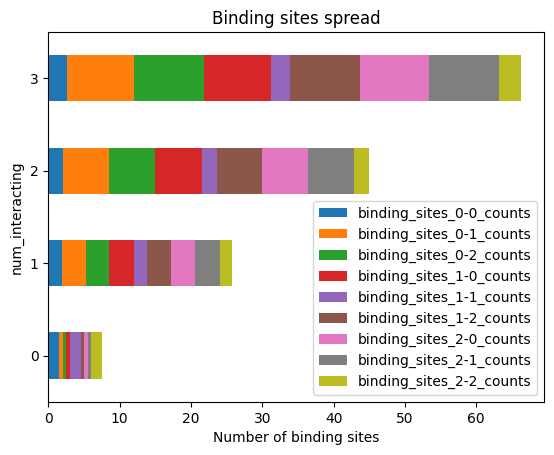

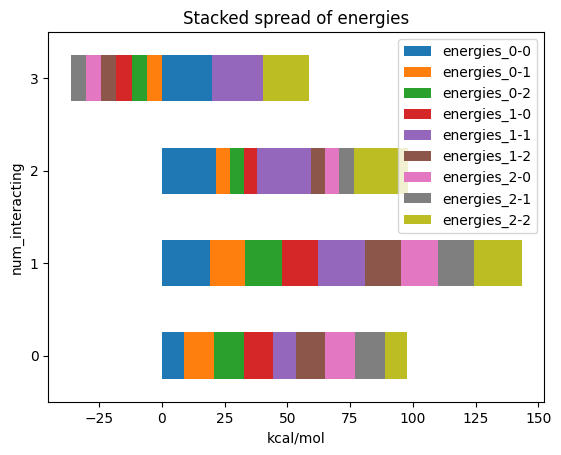

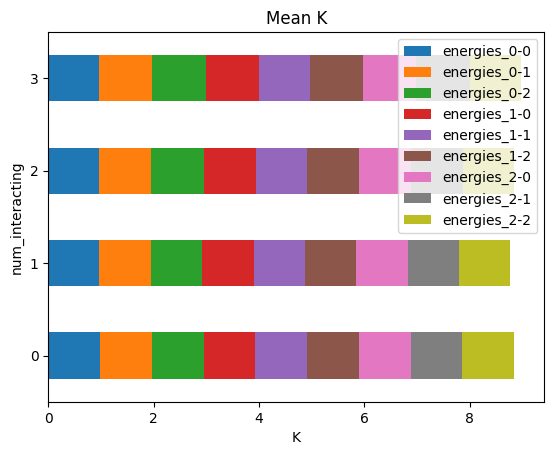

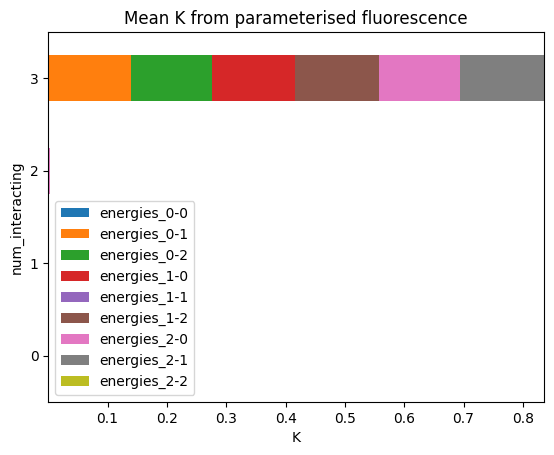

In [ ]:


E = np.arange(-80, 10, 0.5)
E_F_half = E[np.argmax(F(E) >= 0.5)]
initial = np.round(1/1 * (1/F(E_F_half) - 1), 2)

def undo_bplist(bp):
    return np.array([[int(i) for i in p.replace('(', '').replace(')', '').replace('nan', '0').split(',')] for p in str(bp).split(':')])

for c in df.columns:
    if 'binding_sites_' in c and not (('counts' in c) or ('bindratio' in c)):
        df[c + '_counts'] = df[c].apply(str).apply(
            lambda x: len(x.split('nan')[0].split(':')) - (x == 'nan'))
        df[c + '_bindratio'] = df[c].apply(str).apply(
            lambda x: (undo_bplist(x).T[0, -1] - undo_bplist(x).T[0, 0]) / (len(undo_bplist(x)) - 1))

aggd = {c: 'mean'
        for c in df.columns if ('binding_sites_' in c) and (('_counts' in c) or ('_bindratio' in c))}
aggd.update({c: ['mean',
                 lambda x: equilibrium_constant_reparameterisation(np.mean(x), initial)]
             for c in df.columns if 'energies_' in c})

df.groupby(['num_interacting', 'num_self_interacting'], as_index=False).agg(aggd)


aggd = {c: 'mean'
        for c in df.columns if ('binding_sites_' in c) and ('_counts' in c)}

df.groupby('num_interacting', as_index=False).agg(aggd).plot(
    x='num_interacting',
    kind='barh',
    stacked=True,
    title='Binding sites spread',
    mark_right=True)
plt.xlabel('Number of binding sites')
plt.show()

aggd = {c: 'mean'
        for c in df.columns if 'energies_' in c}
df.groupby('num_interacting', as_index=False).agg(aggd).plot(
    x='num_interacting',
    kind='barh',
    stacked=True,
    title='Stacked spread of energies',
    mark_right=True)
plt.xlabel('kcal/mol')
plt.show()
plt.close()

aggd = {c: lambda x: gibbs_K_cal(np.mean(x))
        for c in df.columns if 'energies_' in c}
df.groupby('num_interacting', as_index=False).agg(aggd).plot(
    x='num_interacting',
    kind='barh',
    stacked=True,
    title='Mean K',
    mark_right=True)
plt.xlabel('K')
plt.show()
plt.close()


aggd = {c: lambda x: equilibrium_constant_reparameterisation(np.mean(x), initial)
        for c in df.columns if 'energies_' in c}
df.groupby('num_interacting', as_index=False).agg(aggd).rename(columns={'<lambda_0': 'mean_K-from-F'}).plot(
    x='num_interacting',
    kind='barh',
    stacked=True,
    title='Mean K from parameterised fluorescence',
    mark_right=True)
plt.xlabel('K')
plt.show()
plt.close()


In [ ]:
# config['signal']['function_kwargs']['target'] = 0.5
# config['simulation']['t1'] = 7500
# config['simulation']['dt'] = 0.01
# 
# circuits = CircuitModeller(result_writer=data_writer, config=config).batch_circuits(
#     circuits=circuits,
#     write_to_subsystem=True,
#     batch_size=config['simulation'].get('batch_size', 100),
#     methods={
#         "compute_interactions": {},
#         "init_circuits": {'batch': True},
#         "simulate_signal_batch": {'ref_circuit': None,
#                                   'batch': config['simulation']['use_batch_mutations']},
#         "write_results": {'no_visualisations': config['experiment']['no_visualisations'],
#                           'no_numerical': config['experiment']['no_numerical']}
#     })

# info = b_tabulate_mutation_info(data_writer.ensemble_write_dir,
#                                 data_writer=data_writer, experiment_config=config)
